<a href="https://colab.research.google.com/github/artrucco/Trabalho-LP/blob/main/Trab2LP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UFRJ - Engenharia de Controle e Automação \
Linguagens de Programação - Trabalho 2 \
Professor Claudio Miceli \
Grupo: **Arick, Arthur e Fábio.** \
Tema: Predição de box-office (filmes)

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [240]:
# Data Processing
import numpy as np
import pandas as pd
import json
import ast

# Visualização
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
from wordcloud import WordCloud
from pandas.plotting import scatter_matrix
import plotly.express as px
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz

# Modelo
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

from tqdm import tqdm_notebook

import missingno as msno

In [189]:
test = pd.read_csv('/content/data/test.csv')
train = pd.read_csv('/content/data/train.csv')
submission = pd.read_csv('/content/data/sample_submission.csv')

## **Geral**

In [190]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [191]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [192]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [193]:
#Numero de amostras x Colunas na database
train.shape, test.shape

((3000, 23), (4398, 22))

Apenas 3000 amostras na database de treino. Uma coluna a mais que na de teste, ja que ela possui 'revenue', que é o que busca-se no problema.

In [194]:
#Colunas da database
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

### **Valores Nulos**

In [195]:
#Metodo pd.insull() -> Detecta valores nulos
train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [196]:
test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

"Budget" (orçamento) possui zero valores nulos em ambos os datasets, o que não necessáriamente significa que todos os valores nessa categoria são significantes, podem haver valores "placeholder" como 0.

In [197]:
#Observando a quantidade de vezes em que cada valor unico surge na categoria budget
train.budget.value_counts()

0           812
15000000     72
40000000     71
25000000     71
5000000      68
           ... 
747000        1
1119000       1
65000         1
1750000       1
1135654       1
Name: budget, Length: 406, dtype: int64

O valor '0' aparece 812 vezes, provavelmente pela decorrência da informação não ter sido coletada ou estar disponível, ja que é improvavel que um filme tenha um orçamento nulo.

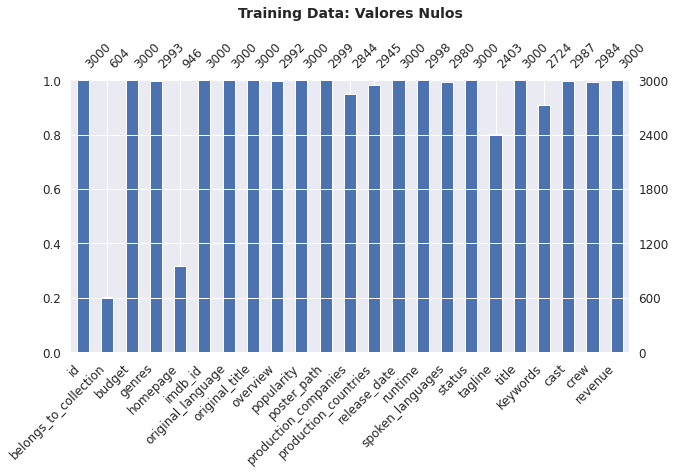

In [198]:
train_miss = msno.bar(train, figsize=(10,5), fontsize=12, color= 'C10').set_title('Training Data: Valores Nulos' '\n', fontweight="bold", fontsize=14)

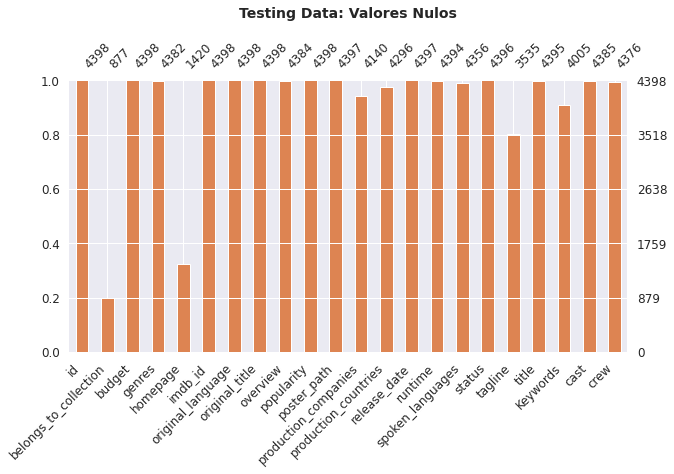

In [199]:
test_miss = msno.bar(test, figsize=(10,5), fontsize=12, color= 'C1').set_title('Testing Data: Valores Nulos' '\n', fontweight="bold", fontsize=14)

Checando as datas de lançamento para valores nulos:

In [200]:
train[train["release_date"].isnull()]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue


Não há valores nulos para data de lançamento na database de treino

In [201]:
test[test["release_date"].isnull()]

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
828,3829,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,...,NaN,NaN,90.0,NaN,NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN


Há uma data com valor nulo para o filme "Jails, Hospitals & Hip-Hop". Como é apenas uma, basta uma rapida pesquisa que podemos encontra-la (1 de Maio/2000) e adicionar na database.

In [222]:
test['release_date'].head()

0    7/14/07
1    5/19/58
2    5/23/97
3     9/4/10
4    2/11/05
Name: release_date, dtype: object

In [225]:
test.loc[test['release_date'].isnull()==True, 'release_date']= '5/1/00'
test[test["release_date"]== '5/1/00']

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,title,Keywords,cast,crew,genres_processed,num_genres,eh_eng,prod_comp_processed,num_produtoras,prod_countries_processed
828,3829,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",0.009057,...,"Jails, Hospitals & Hip-Hop",NaN,[],NaN,[Drama],1,1,[NoCompany],1,[]
1731,4732,NaN,103000000,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,tt0172495,en,Gladiator,"In the year 180, the death of emperor Marcus A...",23.186667,...,Gladiator,"[{'id': 588, 'name': 'rome'}, {'id': 1394, 'na...","[{'cast_id': 8, 'character': 'Maximus', 'credi...","[{'credit_id': '52fe4217c3a36847f800340d', 'de...","[Action, Drama, Adventure]",3,1,"[DreamWorksSKG, UniversalPictures, ScottFreePr...",7,"[UnitedKingdom, UnitedStatesofAmerica]"


Quanto ao restante dos dados, para valores nominais nulos, subtituira-se-á-los com "none", e os valores numericos nulos com a média dos valores válidos.

In [229]:
#substitui nulo com 'none'
train[['cast','crew','genres','original_language', 'spoken_languages','status','production_countries',
       'production_companies']] = train[['cast','crew','genres','original_language', 'spoken_languages','status', 
          'production_countries','production_companies']].fillna("none")
#substitui nulo com media dos validos
train['runtime'] = train['runtime'].fillna(train['runtime'].mean())

test[['cast','crew','genres','original_language', 'spoken_languages','status','production_countries',
       'production_companies']] = test[['cast','crew','genres','original_language', 'spoken_languages','status', 
          'production_countries','production_companies']].fillna("none")

test['runtime'] = test['runtime'].fillna(test['runtime'].mean()) 

In [230]:
#criando uma coluna para mês de lançamento
#formatando as datas
train['release_date'] = pd.to_datetime(train['release_date'], format='%m/%d/%y')
test['release_date'] = pd.to_datetime(test['release_date'], format='%m/%d/%y')
#colunas mês
train["release_month"] = pd.to_datetime(train["release_date"]).dt.month.astype(int)
test["release_month"] = pd.to_datetime(test["release_date"]).dt.month.astype(int)

# **Visualização dos dados:**

---



## **Revenue**

In [263]:
#Analise de Revenue

x = train.revenue
fig = go.Figure(data=[go.Histogram(x=x)])

fig.update_layout(
    title_text='Revenue', # title of plot
    xaxis_title_text='Revenue', # xaxis label
    yaxis_title_text='Número de filmes', # yaxis label
    width = 800,
    height = 450,
)
fig.show()

train['log_revenue'] = np.log(train['revenue'])
x2 = train.log_revenue
fig2 = go.Figure(data=[go.Histogram(x=x2)])

fig2.update_layout(
    title_text='Revenue log', 
    xaxis_title_text='Revenue log',
    yaxis_title_text='Número de filmes',
    width = 800,
    height = 450,
)
fig2.show()



## **Pertence a uma Coleção** 

-> 2396 valores nessa colunas estão vazios, apenas 604 possuem informação.

## **Gêneros**

In [203]:
train.genres.value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                                                 266
[{'id': 35, 'name': 'Comedy'}]                                                                                                                                186
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                                                                               108
[{'id': 35, 'name': 'Comedy'}, {'id': 10749, 'name': 'Romance'}]                                                                                               88
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}]                                                                                                    85
                                                                                                                                                             ... 
[{'id': 12, 'name': 'Adventu

Há filmes com mais de um gênero.

Text(0.5, 1.0, 'Número de filmes por gênero')

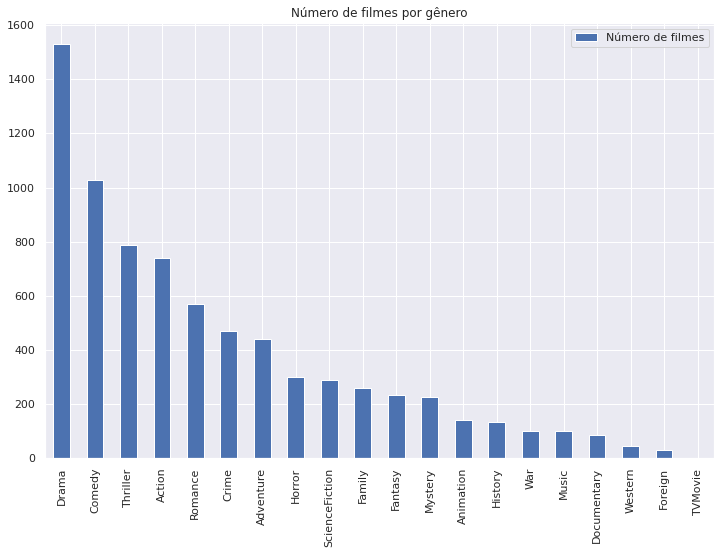

In [204]:
#'Limpa' os itens da coluna genres, remove os colchetes, chaves, espaços, etc. Deixa somente o nome do genero.
def genres_p(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace(' ','').replace("name", "").replace("id", "").replace(":", "")
    ll = str1.split(",")[1::2]
    return ll
#Aplica a função a ambas as db
train["genres_processed"] = train.genres.apply(genres_p)
test["genres_processed"] = test.genres.apply(genres_p)

genres_dict = dict()

for genre in train["genres_processed"]:
    for elem in genre:
        if elem not in genres_dict:
            genres_dict[elem] = 1
        else:
            genres_dict[elem] += 1

#plot
sns.set(rc={'figure.figsize':(12,8)})
genres_df = pd.DataFrame.from_dict(genres_dict, orient='index')
genres_df.columns = ["Número de filmes"]
genres_df = genres_df.sort_values(by="Número de filmes", ascending=False)
genres_df.plot.bar()
plt.title("Número de filmes por gênero")

Text(0.5, 1.0, 'Número de filmes com mais de um gênero')

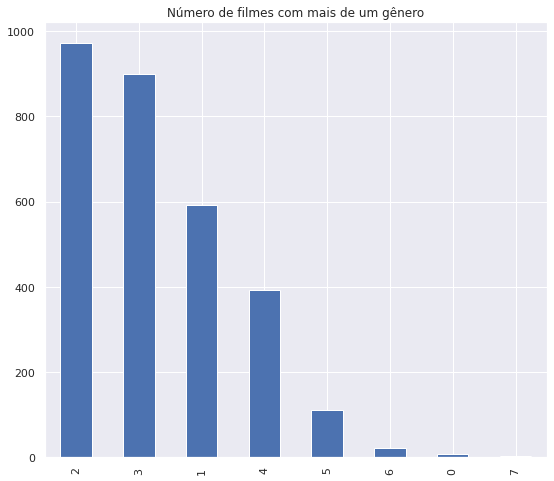

In [205]:
sns.set(rc={'figure.figsize':(9,8)})
train['num_genres'] = train['genres_processed'].apply(lambda x: len(x) if x != {} else 0)
test['num_genres'] = test['genres_processed'].apply(lambda x: len(x) if x != {} else 0)

train['num_genres'].value_counts().plot.bar()
plt.title("Número de filmes com mais de um gênero")

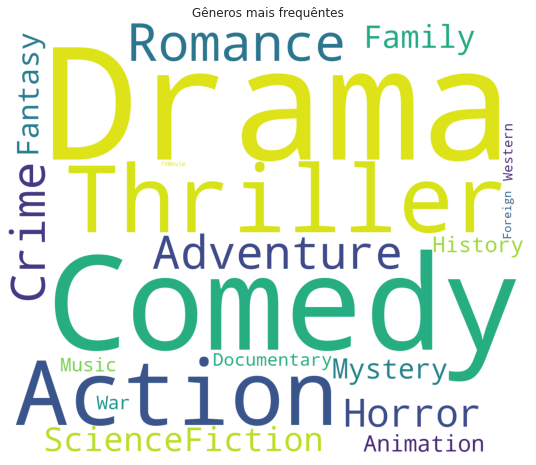

In [206]:
lista_genres = train["genres_processed"]
plt.figure(figsize = (12, 8))
text = ' '.join([i for j in lista_genres for i in j])
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Gêneros mais frequêntes')
plt.axis("off")
plt.show()

In [207]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'genres_processed', 'num_genres'],
      dtype='object')

## **Linguagem**

In [208]:
#Contagem de filmes por lingua
pd.DataFrame(train.original_language.value_counts()).T

,en,fr,ru,es,hi,ja,it,cn,ko,zh,...,he,el,ar,nb,vi,mr,cs,sr,bn,id
original_language,2575,78,47,43,42,37,24,20,20,19,...,1,1,1,1,1,1,1,1,1,1


Text(0.5, 1.0, 'Distribuição de filmes por linguagem')

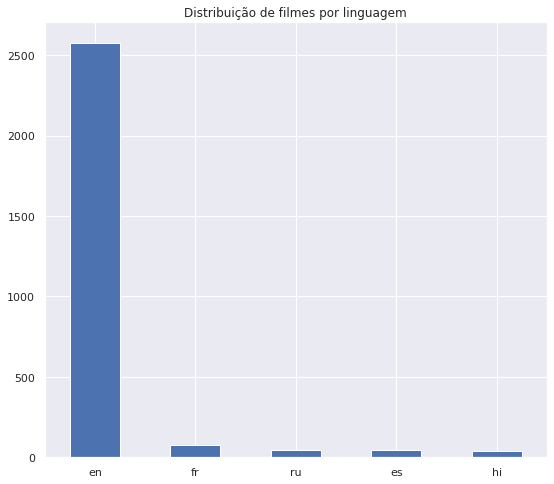

In [209]:
#Distribuição de filmes por linguagem - 5 Linguas mais ocorrentes
linguas_top5 = train['original_language'].value_counts()[:5]
linguas_top5.plot.bar()
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('Distribuição de filmes por linguagem')

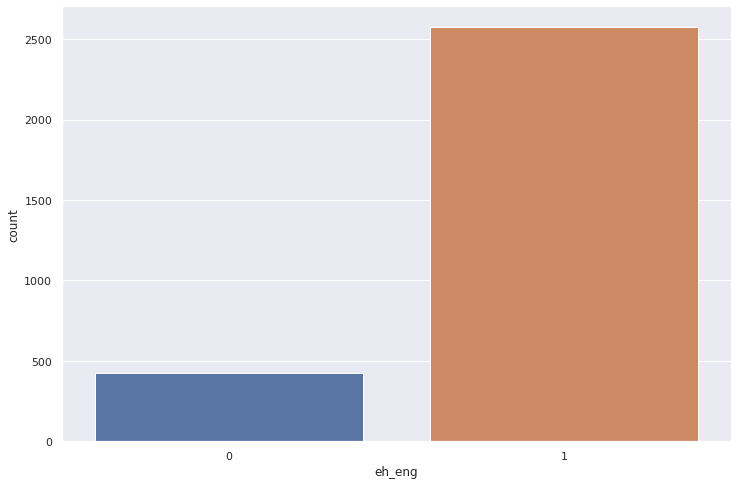

In [210]:
#Categorização entre filmes em inglês ou outra lingua
train["eh_eng"] = train.original_language.apply(lambda x: 1 if x=="en" else 0)
test["eh_eng"] = test.original_language.apply(lambda x: 1 if x=="en" else 0)

#substituir valores nulos com 1
train.eh_eng = train.eh_eng.fillna(1)
test.eh_eng = test.eh_eng.fillna(1)

#plot
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(x="eh_eng", data=train)

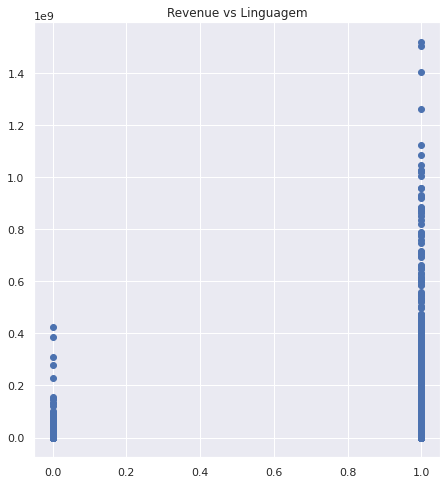

In [211]:
#Relação entre lingua inglesa e lucro
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['eh_eng'], train['revenue'])
plt.title('Revenue vs Linguagem');

## **Produtoras**

In [212]:
train['production_companies'].head()

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                  NaN
4                                                  NaN
Name: production_companies, dtype: object

In [213]:
train.production_companies.value_counts()

[{'name': 'Paramount Pictures', 'id': 4}]                                                                                                                                                                                                                     51
[{'name': 'Universal Pictures', 'id': 33}]                                                                                                                                                                                                                    36
[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]                                                                                                                                                                                                           32
[{'name': 'Warner Bros.', 'id': 6194}]                                                                                                                                                                                               

A coluna referente às produtoras sofre do mesmo problema que os gêneros em que precisa ser feita uma limpagem nos dados.

Text(0.5, 1.0, 'Número de filmes por produtora')

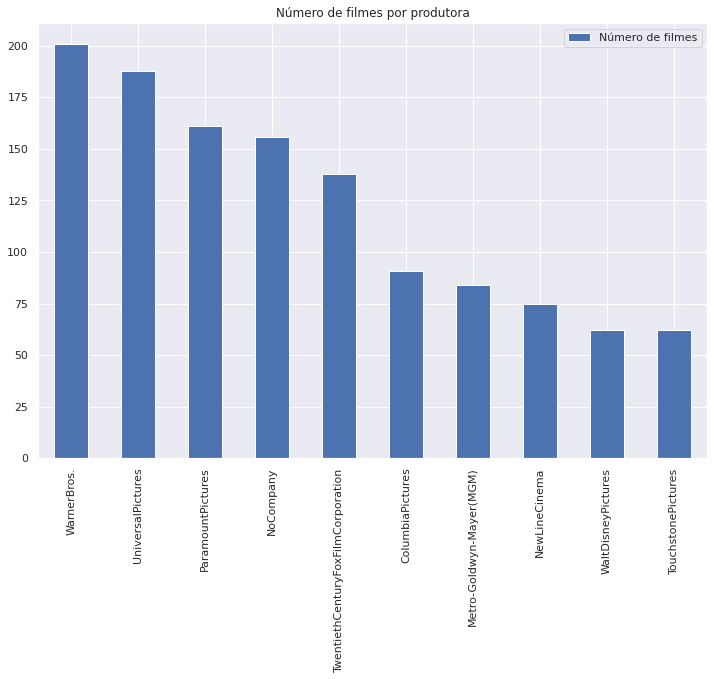

In [214]:
#'Limpa' os itens da coluna production_companies, remove os colchetes, chaves, espaços, etc. Deixa somente o nome do genero.
def prod_comp_processed(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace(' ','').replace("name", "").replace("id", "").replace(":", "").replace("\'", "")
    ll = str1.split(",")[0::2]
    return ll

#train["production_companies"] = train.production_companies.fillna('NoCompany')
#test["production_companies"] = test.production_companies.fillna('NoCompany')

#Aplica a função a ambas as db
train["prod_comp_processed"] = train.production_companies.apply(prod_comp_processed)
test["prod_comp_processed"] = test.production_companies.apply(prod_comp_processed)

#criar e indexar dicionario com os valores nominais das produtoras
production_companies_dict = dict()

for production_company in train["prod_comp_processed"]:
    for elem in production_company:
        if elem not in production_companies_dict:
            production_companies_dict[elem] = 1
        else:
            production_companies_dict[elem] += 1

sns.set(rc={'figure.figsize':(12,8)})
production_companies_df = pd.DataFrame.from_dict(production_companies_dict, orient='index')
production_companies_df.columns = ["Número de filmes"]
production_companies_df = production_companies_df.sort_values(by="Número de filmes", ascending=False)
production_companies_df.head(10).plot.bar()
plt.title("Número de filmes por produtora")

Text(0.5, 1.0, 'Número de produtoras por filme')

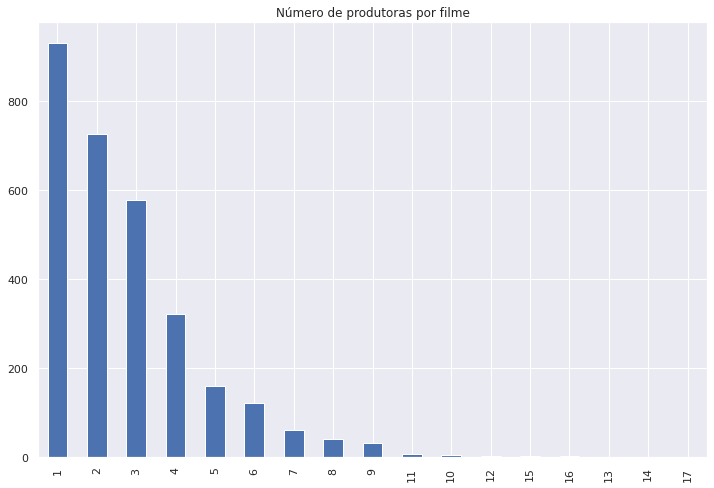

In [215]:
#Observa os casos em que há mais de uma produtora por filme
train['num_produtoras'] = train.prod_comp_processed.apply(len)
test['num_produtoras'] = test.prod_comp_processed.apply(len)
train['num_produtoras'].value_counts().plot.bar()
plt.title('Número de produtoras por filme')

## **Numero de países na produção**




In [216]:
train['production_countries'].head()

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3              [{'iso_3166_1': 'IN', 'name': 'India'}]
4        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
Name: production_countries, dtype: object

In [217]:
train['production_countries'].value_counts()

[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                                                                                                                    1752
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]                                                                                                                                     118
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                                                                                                                                                                94
[{'iso_3166_1': 'IN', 'name': 'India'}]                                                                                                                                                                                                         69
[{'iso_3166_1': 'FR', 'name'

Há casos em que produtoras de diferentes países trabalham em um mesmo projeto.

Text(0.5, 1.0, 'Número de filmes por país de produção')

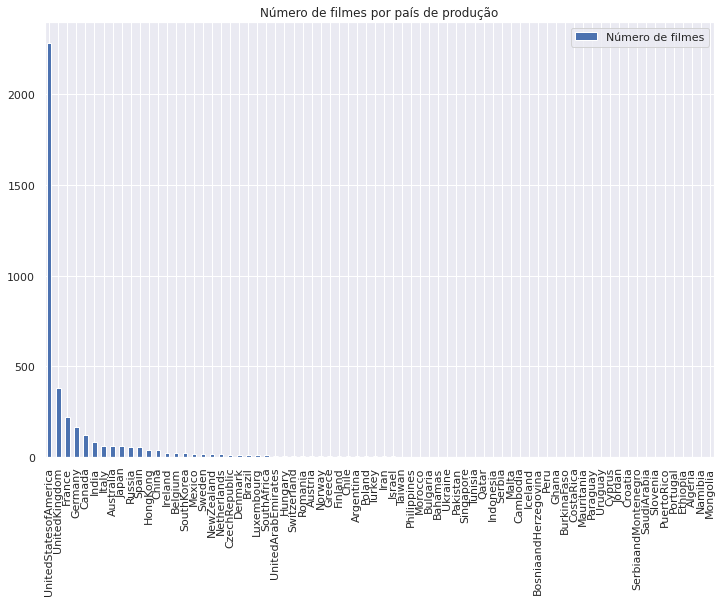

In [218]:
def prod_countries(elem):
    string = str(elem)
    str1 = string.replace(']','').replace('[','').replace('{','').replace('}','').replace('\'','').replace(' ','').replace("name", "").replace("id", "").replace(":", "")
    ll = str1.split(",")[1::2]
    return ll
#Aplica a função a ambas as db
train["prod_countries_processed"] = train.production_countries.apply(prod_countries)
test["prod_countries_processed"] = test.production_countries.apply(prod_countries)

prod_countries_dict = dict()

for country in train["prod_countries_processed"]:
    for elem in country:
        if elem not in prod_countries_dict:
            prod_countries_dict[elem] = 1
        else:
            prod_countries_dict[elem] += 1

#plot
sns.set(rc={'figure.figsize':(12,8)})
prod_countries1 = pd.DataFrame.from_dict(prod_countries_dict, orient='index')
prod_countries1.columns = ["Número de filmes"]
prod_countries1 = prod_countries1.sort_values(by="Número de filmes", ascending=False)
prod_countries1.plot.bar()
plt.title("Número de filmes por país de produção")

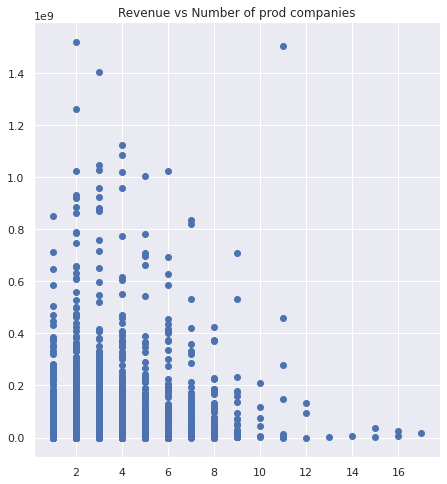

In [219]:
#Relação entre numero de produtoras e lucro
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_produtoras'], train['revenue'])
plt.title('Revenue vs Number of prod companies');

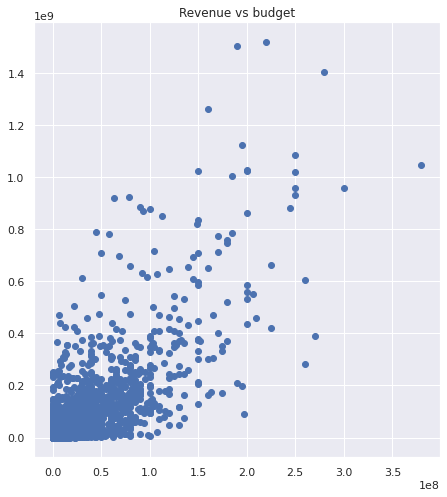

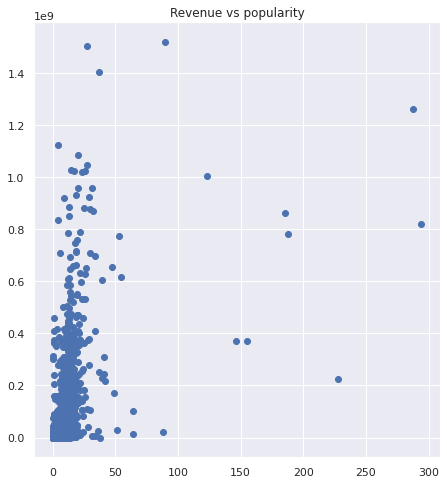

In [220]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget'], train['revenue'])
plt.title('Revenue vs budget');

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['popularity'], train['revenue'])
plt.title('Revenue vs popularity');

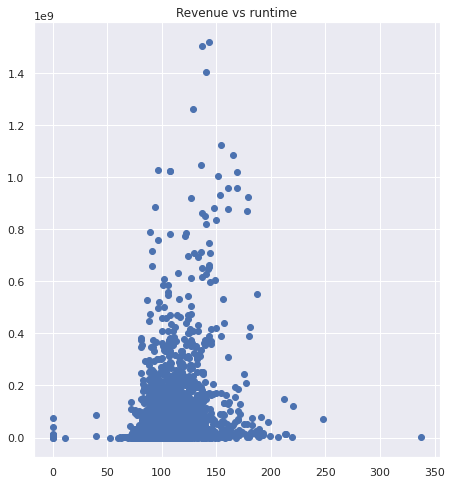

In [221]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['runtime'], train['revenue'])
plt.title('Revenue vs runtime');


**Random Forest**